# Using Syllabus

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn import tree

import nltk
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import MNLogit
from scipy import stats
import spacy

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from textmining import TermDocumentMatrix

C:\Users\fzy20\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
joined_df = pd.read_csv('joined_final.csv')
print(len(joined_df))

2587


## Data Cleaning

In [11]:
#Useless word dictionary
useless_words = ["class","cours","exam","assign","student","grade","case",
                 "recit","read","lectur","recit","note","session","final",
                "particip","problem","homework","team","member","quiz","paper"
                 ,"point","absenc","deadlin","mon","midterm","lesson","thurs","tue","wed",
                "septemb","novemb","jmhh","april","chap",'mar','apr','feb',"fall","spring",'use']

In [9]:
def first_strings(x,num):
    return x[0:num]
vect_strings = np.vectorize(first_strings)

In [8]:
# function to clean the syllabus
stopword = set(stopwords.words('english'))
stopword.add("'s")
stemmer = PorterStemmer()
def is_word(x):
    return len(re.findall('[0-9' + string.punctuation + ']', x)) == 0
def clean_syllabus(syllabus):
    # tokenizes it using nltk.word_tokenize
    result = word_tokenize(syllabus)
    
    # converts it to lower case
    result = [token.lower() for token in result]
    
    # removes stopwords that are present in the set from the cell above
    result = [token for token in result if not token in stopword]
    
    # uses stemmer to cut the word down to its stem
    result = [stemmer.stem(token) for token in result]
    
    # uses has_letter to remove words that don't have any letters
    result = [token for token in result if is_word(token) == True]
    
    # keeps only those words with length greater than 1 and less than 20.
    result = [token for token in result if ((len(token) > 2) and (len(token) < 20))]
    
    result = [token for token in result if token not in useless_words]
    
    return result

# Corpus Processing

In [5]:
descrip = pd.read_csv("description_data.csv")

In [6]:
descrip.head(5)

,description,course,name
0,"Through the process of action, reflection, and...",MGMT100,Ldershp & Commun In Grps
1,We all spend much of our lives in organization...,MGMT101,Intro To Management
2,This undergraduate core course introduces stud...,MGMT104,Indus Rel & Hum Res Mgmt
3,Multinational management is the study of the i...,MGMT111,Multinational Management
4,The half-credit (0.5 CU) Managing Disruptive C...,MGMT198,Special Topics Isp


In [12]:
desc_list = {}
train_set = descrip
length = len(train_set)

for i in range(length):
    desc_list[i] = clean_syllabus(descrip['description'][i])

processed_desc = []
for i in desc_list:
    processed_desc.append(desc_list.get(i))

In [13]:
type(processed_desc[0][0])

str

In [17]:
bigram = gensim.models.Phrases(processed_desc, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[processed_desc], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [18]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [19]:
# Form Bigrams
processed_desc_bigrams = make_bigrams(processed_desc)

In [20]:
dictionary = gensim.corpora.Dictionary(processed_desc)

In [21]:
#dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [22]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_desc_bigrams]

# Modelling

In [131]:
lda_model_desc = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                           id2word=dictionary,
                                           num_topics=30, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [132]:
for idx, topic in lda_model_desc.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.115*"financi" + 0.066*"firm" + 0.050*"corpor" + 0.047*"asset" + 0.034*"career" + 0.027*"invest" + 0.027*"statement" + 0.026*"implic" + 0.024*"secur" + 0.022*"capit"
Topic: 1 
Words: 0.051*"survey" + 0.049*"number" + 0.041*"stock" + 0.030*"servic" + 0.027*"distribut" + 0.024*"simpl" + 0.024*"invest" + 0.023*"common" + 0.018*"mix" + 0.017*"display"
Topic: 2 
Words: 0.047*"design" + 0.042*"technolog" + 0.040*"appli" + 0.031*"need" + 0.031*"level" + 0.030*"interest" + 0.026*"intermedi" + 0.025*"innov" + 0.025*"four" + 0.023*"product"
Topic: 3 
Words: 0.126*"regress" + 0.071*"random" + 0.036*"model" + 0.034*"stat" + 0.030*"electron" + 0.030*"logist" + 0.027*"famili" + 0.021*"delv" + 0.020*"methodolog" + 0.018*"select"
Topic: 4 
Words: 0.000*"social" + 0.000*"creat" + 0.000*"entrepreneurship" + 0.000*"profit" + 0.000*"gener" + 0.000*"public" + 0.000*"enterpris" + 0.000*"product" + 0.000*"develop" + 0.000*"ventur"
Topic: 5 
Words: 0.043*"risk" + 0.039*"polici" + 0.028*"mark

In [133]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_desc.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_desc, texts=processed_desc_bigrams, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.643746759264847

Coherence Score:  0.3691456938562912


In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=bow_corpus, texts=processed_desc_bigrams, 
                                                        start=20, limit=100, step=6)

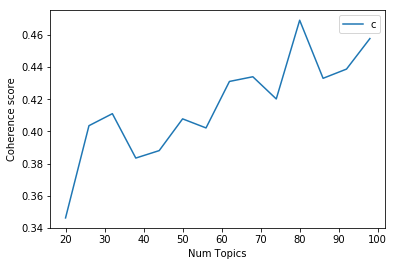

In [163]:
# Show graph
limit=100; start=20; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 20  has Coherence Value of 0.3462
Num Topics = 26  has Coherence Value of 0.4035
Num Topics = 32  has Coherence Value of 0.411
Num Topics = 38  has Coherence Value of 0.3834
Num Topics = 44  has Coherence Value of 0.3881
Num Topics = 50  has Coherence Value of 0.4078
Num Topics = 56  has Coherence Value of 0.4022
Num Topics = 62  has Coherence Value of 0.431
Num Topics = 68  has Coherence Value of 0.434
Num Topics = 74  has Coherence Value of 0.4202
Num Topics = 80  has Coherence Value of 0.4691
Num Topics = 86  has Coherence Value of 0.433
Num Topics = 92  has Coherence Value of 0.4387
Num Topics = 98  has Coherence Value of 0.4577


In [31]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
Topic_list = []
for idx, topic in optimal_model.print_topics(-1):
    Topic_list.append('Topic: {} Words: {}'.format(idx, topic))

In [32]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
23     0.188356 -0.001532       1        1  12.106778
21     0.268949  0.050728       2        1  11.837971
20     0.198761  0.142284       3        1  10.738787
8      0.222231  0.021808       4        1   8.854086
5      0.213759 -0.156670       5        1   7.552108
18     0.209006  0.086334       6        1   7.349616
29     0.141220 -0.186517       7        1   5.570845
22     0.134795 -0.101014       8        1   4.565590
12     0.074637  0.145596       9        1   3.415884
25    -0.006134  0.089889      10        1   3.374795
30    -0.040356  0.004244      11        1   2.976642
28     0.053408  0.152091      12        1   2.880843
19     0.011517  0.059392      13        1   2.380234
15     0.078436 -0.243369      14        1   2.310774
0      0.010574 -0.060350      15        1   2.157158
2      0.026651  0.071193      16        1   1.935007
11    -0.029477  0.055227      17        1   1.897817
3      0.013323 -0.026908      18        1   1.595542
1     -0.080516 -0.003476      19        1   1.535221
10    -0.060478 -0.052948      20        1   1.444592
6     -0.104506 -0.018799      21        1   1.128865
27    -0.124184  0.021613      22        1   0.619511
4     -0.153844  0.003981      23        1   0.423796
9     -0.146418 -0.023893      24        1   0.336008
26    -0.155777 -0.001355      25        1   0.301434
31    -0.148822 -0.002268      26        1   0.266589
16    -0.139654 -0.018572      27        1   0.208574
24    -0.140904 -0.010640      28        1   0.150777
7     -0.128638  0.000983      29        1   0.021382
14    -0.128638  0.000983      30        1   0.021284
13    -0.128638  0.000982      31        1   0.020849
17    -0.128638  0.000982      32        1   0.020645, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
594   Default   90.000000         data   90.000000  30.0000  30.0000
99    Default   88.000000         firm   88.000000  29.0000  29.0000
371   Default   72.000000        price   72.000000  28.0000  28.0000
6     Default  178.000000         busi  178.000000  27.0000  27.0000
165   Default  107.000000       econom  107.000000  26.0000  26.0000
432   Default   58.000000          law   58.000000  25.0000  25.0000
160   Default   46.000000     behavior   46.000000  24.0000  24.0000
603   Default  139.000000       includ  139.000000  23.0000  23.0000
3     Default  103.000000       applic  103.000000  22.0000  22.0000
506   Default   43.000000      creativ   43.000000  21.0000  21.0000
372   Default   86.000000      product   86.000000  20.0000  20.0000
81    Default   86.000000      analysi   86.000000  19.0000  19.0000
173   Default  235.000000       market  235.000000  18.0000  18.0000
396   Default   76.000000      financi   76.000000  17.0000  17.0000
180   Default   98.000000       polici   98.000000  16.0000  16.0000
412   Default   45.000000       public   45.000000  15.0000  15.0000
129   Default   27.000000       system   27.000000  14.0000  14.0000
370   Default   89.000000        model   89.000000  13.0000  13.0000
127   Default   65.000000     strategi   65.000000  12.0000  12.0000
90    Default   77.000000        decis   77.000000  11.0000  11.0000
207   Default   54.000000     industri   54.000000  10.0000  10.0000
246   Default   40.000000      strateg   40.000000   9.0000   9.0000
35    Default  148.000000        manag  148.000000   8.0000   8.0000
169   Default   57.000000       govern   57.000000   7.0000   7.0000
656   Default   61.000000       financ   61.000000   6.0000   6.0000
460   Default   55.000000    technolog   55.000000   5.0000   5.0000
163   Default   73.000000        cover   73.000000   4.0000   4.0000
1489  Default   51.000000       consum   51.000000   3.0000   3.0000
120   Default   50.000000        organ   50.000000 

In [33]:
topic_vec = []
perc_vec = []
for i in np.arange(0,len(bow_corpus)):
    unseen = bow_corpus[i]
    vector = optimal_model[unseen][0]
    topic_vec.append(np.array(vector)[:,0][np.where(np.array(vector)[:,1] == np.max(np.array(vector)[:,1]))[0]][0])
    perc_vec.append(np.max(np.array(vector)[:,1]))

In [34]:
from collections import Counter
key_value = Counter(topic_vec)
Grouped = (sorted(key_value.items(), key = 
             lambda kv:(kv[1], kv[0]))) 

In [35]:
index = np.array(Grouped)[:,0].astype(int)
Topic_list = np.array(Topic_list)[np.sort(index)]

In [36]:
Topic_Count = pd.DataFrame(Grouped,columns=['Topic_index', 'count']).sort_values('Topic_index')

In [1]:
descrip['topic'] = topic_vec
descrip['perc'] = perc_vec
descrip.loc[descrip['topic'] == 11,:]

NameError: name 'topic_vec' is not defined

In [495]:
Topic_name[30]

'Business Impact'

In [45]:
Topic_name = ['Resource Management','Finiancial Analytics','Behaviorial Economics',
              'Strategic Competitions','Social Entrepreneurship','Market Economics',
              'Financial Decision Making','Start Ups and Innovations','Quantitative Approach in Business',
             'Economic Systems', "Investment Banking","Diversity of Impact","Technology Ventures","Energy and Enviroment",
             'Business Ecosystem','Fiscal Policies','Technology and Responsibility','Field Application','Management Modelling',
             'Information Strategy','Product Technology Intergration','Business Decision Making','Consumer Economics',
             'Global Markets','Sophomore stuff','Statistical Analysis','Case-based courses','Business and Metrics','Human Relation',
             'Law and Business','Business Impact','Financial Transactions']

In [41]:
unseen = bow_corpus[0]
vector = optimal_model[unseen][0]

In [42]:
base_frame = pd.DataFrame(columns = ["Class", "Name"]+list(np.arange(0,31)))
for i in np.arange(0,len(bow_corpus)):
    unseen = bow_corpus[i]
    vector = optimal_model[unseen][0]
    base = pd.DataFrame(np.array(vector).transpose())
    base.columns = base.iloc[0,:]
    base = base.drop([0]).astype(float)
    base['Class'] = descrip.course[i]
    base['Name'] = descrip.name[i]
    base_frame = base_frame.append(base, sort = True).fillna(0)

In [43]:
len(Topic_list)

24

In [46]:
base_frame.columns = ['Class','Name'] + Topic_name

In [47]:
base_frame.sort_values(by=['Statistical Analysis'],ascending=False)

,Class,Name,Resource Management,Finiancial Analytics,Behaviorial Economics,Strategic Competitions,Social Entrepreneurship,Market Economics,Financial Decision Making,Start Ups and Innovations,...,Consumer Economics,Global Markets,Sophomore stuff,Statistical Analysis,Case-based courses,Business and Metrics,Human Relation,Law and Business,Business Impact,Financial Transactions
1,STAT101,Intro Business Stat,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.027279,0.913490,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,STAT111,Introductory Statistics,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.011507,0.000000,0.889827,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,STAT102,Intro Business Stat,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.011490,0.000000,0.889771,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,OIDD299,Judg & Dec Making Res Im,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.686628,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,STAT112,Introductory Statistics,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.279383,0.0,...,0.000000,0.013791,0.000000,0.601767,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,STAT511,Statistical Inference,0.000000,0.211285,0.000000,0.000000,0.000000,0.000000,0.054112,0.0,...,0.000000,0.012102,0.000000,0.501327,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,STAT516,Adv Stat Inference Ii,0.068313,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.014146,0.000000,0.462254,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,STAT431,Statistical Inference,0.000000,0.224264,0.055143,0.000000,0.000000,0.000000,0.043367,0.0,...,0.000000,0.000000,0.000000,0.447514,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,STAT474,Modern Regression,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.012286,0.000000,0.412534,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,STAT512,Mathematical Statistics,0.000000,0.000000,0.055087,0.000000,0.000000,0.000000,0.111794,0.0,...,0.000000,0.012320,0.000000,0.381563,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


In [443]:
base_frame.loc[base_frame['Class'] == "FNCE203 ",]

,Class,Name,Resource Management,Finiancial Analytics,Behaviorial Economics,Strategic Comeptitions,Social Entrepreneurship,Market Economics,Financial Decision Making,Start Ups and Innovations,...,Consumer Economics,Global Markets,Sophomore stuff,Statistical Analysis,Case-based courses,Business and Metrics,Human Relation,Law and Business,Business Impact,Financial Transactions
1,FNCE203,Advanced Corp Finance,0.115346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.506804,0.0,0.0


In [437]:
np.unique(base_frame['Class'])

array(['ACCT101 ', 'ACCT102 ', 'ACCT212 ', 'ACCT242 ', 'ACCT243 ',
       'ACCT270 ', 'ACCT297 ', 'ACCT399 ', 'BEPP201 ', 'BEPP203 ',
       'BEPP208 ', 'BEPP210 ', 'BEPP212 ', 'BEPP214 ', 'BEPP220 ',
       'BEPP230 ', 'BEPP233 ', 'BEPP236 ', 'BEPP250 ', 'BEPP261 ',
       'BEPP263 ', 'BEPP280 ', 'BEPP284 ', 'BEPP289 ', 'BEPP305 ',
       'BEPP322 ', 'BEPP452 ', 'BEPP454 ', 'FNCE100 ', 'FNCE101 ',
       'FNCE203 ', 'FNCE205 ', 'FNCE206 ', 'FNCE207 ', 'FNCE208 ',
       'FNCE209 ', 'FNCE219 ', 'FNCE220 ', 'FNCE230 ', 'FNCE235 ',
       'FNCE238 ', 'FNCE239 ', 'FNCE250 ', 'FNCE251 ', 'FNCE254 ',
       'FNCE256 ', 'FNCE283 ', 'FNCE291 ', 'FNCE311 ', 'FNCE384 ',
       'FNCE385 ', 'FNCE386 ', 'FNCE387 ', 'FNCE393 ', 'FNCE395 ',
       'HCMG101 ', 'HCMG202 ', 'HCMG203 ', 'HCMG204 ', 'HCMG212 ',
       'HCMG213 ', 'HCMG215 ', 'HCMG216 ', 'HCMG250 ', 'HCMG302 ',
       'HCMG352 ', 'HCMG391 ', 'LGST100 ', 'LGST101 ', 'LGST202 ',
       'LGST205 ', 'LGST206 ', 'LGST207 ', 'LGST208 ', 'LGST21